<a href="https://colab.research.google.com/github/davidelgas/DataSciencePortfolio/blob/main/Knowledge%2520Graph%20/eComm_Knowledge_Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

In this notebook I will be creating a knowledge graph with an open source e-Commerce dataset.


My use case:<br>
Build an eCommerce Knowledge Graph with purchase recommendations.

# Dataset
Ill be using the COOKIE dataset<br>
https://github.com/zuohuif/COOKIE<br>
https://drive.google.com/drive/folders/1gOIsuy3RSqi3UbTnfYyzgVS7msQVRKU5

# Load Data

In [ ]:
# Access to Google Drive
# This seems to propagate credentials better from its own cell

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Load the training data and do a little exploration
file_path = "/content/drive/Othercomputers/My Mac/CSCI_104/Project/Datasets/Cell_Phones_and_Accessories/minimal/dial_gt_context_train.npz"
data = np.load(file_path, allow_pickle=True)

# List the arrays stored inside the file
print("Stored arrays:", data.files)

# Loop through each stored array and print its shape and a sample of its content
for key in data.files:
    array = data[key]
    print(f"\nKey: {key}")
    print(f"Shape: {array.shape}")
    print(f"Type: {type(array)}")

    # Print the first few entries for inspection
    if isinstance(array, np.ndarray):
        print(f"First 5 entries:\n{array[:5]}")
    else:
        print(f"First 5 entries (non-numpy type): {array[:5]}")


Stored arrays: ['utter_gt', 'utter_context', 'resp_gt', 'resp_context']

Key: utter_gt
Shape: (361590, 10, 1)
Type: <class 'numpy.ndarray'>
First 5 entries:
[[[169331]
  [169331]
  [169331]
  [169331]
  [169331]
  [169331]
  [135181]
  [169331]
  [128901]
  [169331]]

 [[139397]
  [169331]
  [168871]
  [169331]
  [163173]
  [169331]
  [160426]
  [169331]
  [115820]
  [169331]]

 [[128860]
  [169331]
  [118697]
  [169331]
  [114104]
  [169331]
  [109083]
  [169331]
  [115820]
  [169331]]

 [[139439]
  [169331]
  [129237]
  [169331]
  [128901]
  [169331]
  [122498]
  [169331]
  [114104]
  [169331]]

 [[139435]
  [169331]
  [137017]
  [169331]
  [129237]
  [169331]
  [114104]
  [169331]
  [115820]
  [169331]]]

Key: utter_context
Shape: (361590, 10, 24)
Type: <class 'numpy.ndarray'>
First 5 entries:
[[[169331     45 169331 ... 169331     45 169331]
  [169331     45 169331 ... 169331     45 169331]
  [169331     45 169331 ... 169331     45 169331]
  ...
  [169331     45 169331 ... 169331  

In [ ]:
# Load pre-trained word embeddings

word_embed_file = "/content/drive/Othercomputers/My Mac/CSCI_104/Project/Datasets/Cell_Phones_and_Accessories/minimal/dial_word_embed.npz"
word_embed_data = np.load(word_embed_file, allow_pickle=True)

# Check stored variables
print("Stored arrays in dial_word_embed.npz:", word_embed_data.files)

# Check the shape of embeddings
if "word_emb" in word_embed_data:
    embeddings = word_embed_data["word_emb"]
    print("Word embedding shape:", embeddings.shape)

    # Print first 5 rows
    print("First 5 word embeddings:\n", embeddings[:5])


Stored arrays in dial_word_embed.npz: ['word_emb']
Word embedding shape: (19071, 200)
First 5 word embeddings:
 [[ 1.23679310e-03  1.15482610e-03 -1.97899920e-03 -5.45953700e-05
  -2.25469450e-03 -1.73265080e-03 -2.32556490e-03  1.30943220e-03
  -7.85789160e-04  1.42404150e-03  1.80158600e-03 -1.24118350e-03
   8.28349200e-05 -2.18325430e-03 -2.46739480e-03  1.23268870e-03
  -1.08284640e-03 -5.83230050e-04  1.11434240e-03 -2.36627200e-03
  -4.59292800e-04 -2.36549000e-03  9.70530000e-04 -7.91465300e-04
   1.79398700e-03 -2.42010920e-03 -1.06402990e-03  1.60729160e-03
   1.96189950e-03  2.08600500e-03  1.66028050e-04  2.87028160e-05
   1.19609070e-03  1.69859510e-03  1.25612660e-03 -2.00261500e-03
  -6.41188640e-04  5.51312600e-04  1.38313800e-03 -1.09464240e-03
   1.00284970e-03  2.17142330e-03 -1.54237430e-03  3.29636850e-04
  -2.17077740e-05 -1.77721360e-03 -6.71590900e-04  1.82876480e-03
  -2.05638960e-03  1.86594760e-03  1.64006720e-03  8.50609200e-04
   1.77565200e-03  2.43466160e

In [ ]:
# Path to dictionary

word_dict_path = "/content/drive/Othercomputers/My Mac/CSCI_104/Project/Datasets/Cell_Phones_and_Accessories/minimal/word_dict.txt"

# Load the word dictionary
word_to_id = {}
id_to_word = {}

with open(word_dict_path, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 2:  # Ensure valid format
            word = parts[0]
            index = int(parts[1])
            word_to_id[word] = index
            id_to_word[index] = word  # Reverse lookup

# Check first 10 entries
print("First 10 Word-ID Mappings:")
for i, (word, index) in enumerate(word_to_id.items()):
    print(f"{index}: {word}")
    if i == 9:
        break


First 10 Word-ID Mappings:
786: militaryshield
3464: 6.6ft
8135: circuitri
12798: c-pattern-4
15378: zedari
7476: 20000mah-black
16861: rvh-ac03
3592: hanlesi
709: yellow
5354: interchang


In [ ]:
# Load KG data

# File paths for KG-related files
kg_user_entities_path = "/content/drive/Othercomputers/My Mac/CSCI_104/Project/Datasets/Cell_Phones_and_Accessories/KG-related_Files/kg_users_Cell_Phones_and_Accessories.txt"
kg_item_entities_path = "/content/drive/Othercomputers/My Mac/CSCI_104/Project/Datasets/Cell_Phones_and_Accessories/KG-related_Files/kg_items_Cell_Phones_and_Accessories.txt"
kg_other_entities_path = "/content/drive/Othercomputers/My Mac/CSCI_104/Project/Datasets/Cell_Phones_and_Accessories/KG-related_Files/kg_other_entities_Cell_Phones_and_Accessories.txt"

# Function to load entities
def load_entities(file_path, entity_type):
    entities = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) == 2:
                name, entity_id = parts
                entity_name = name.split("::")[1]  # Remove entity type prefix
                entities.append((entity_id, entity_name, entity_type))
    return entities

# Load entities
user_entities = load_entities(kg_user_entities_path, "user")
item_entities = load_entities(kg_item_entities_path, "item")
other_entities = load_entities(kg_other_entities_path, "other")

# Combine into a DataFrame
kg_entities_df = pd.DataFrame(user_entities + item_entities + other_entities, columns=["Entity_ID", "Entity_Name", "Entity_Type"])

# Display first few rows
print("First few rows of the Knowledge Graph Entities DataFrame:")
print(kg_entities_df.head())  # Print the first few rows

First few rows of the Knowledge Graph Entities DataFrame:
  Entity_ID     Entity_Name Entity_Type
0         0   A1M117A53LEI8        user
1         1  A272DUT8M88ZS8        user
2         2  A1DW2L6XCC5TJS        user
3         3   AQC61R4UST7UH        user
4         4  A31OVFL91BCKXG        user


In [ ]:
# Load edges

# File paths
kg_relations_path = "/content/drive/Othercomputers/My Mac/CSCI_104/Project/Datasets/Cell_Phones_and_Accessories/KG-related_Files/kg_relations_Cell_Phones_and_Accessories.txt"
kg_train_triples_path = "/content/drive/Othercomputers/My Mac/CSCI_104/Project/Datasets/Cell_Phones_and_Accessories/KG-related_Files/kg_train_triples_Cell_Phones_and_Accessories.txt"
kg_other_triples_path = "/content/drive/Othercomputers/My Mac/CSCI_104/Project/Datasets/Cell_Phones_and_Accessories/KG-related_Files/kg_other_triples_Cell_Phones_and_Accessories.txt"

# Load Relations
relations = []
with open(kg_relations_path, "r", encoding="utf-8") as f:
    for line in f:
        relation, relation_id = line.strip().split("\t")
        relations.append((relation_id, relation))

relations_df = pd.DataFrame(relations, columns=["Relation_ID", "Relation_Name"])

# Load Triples (Train + Other)
def load_triples(file_path):
    triples = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            head, tail, relation = line.strip().split("\t")
            triples.append((head, relation, tail))
    return triples

train_triples = load_triples(kg_train_triples_path)
other_triples = load_triples(kg_other_triples_path)

# Convert to DataFrame
train_triples_df = pd.DataFrame(train_triples, columns=["Head_Entity", "Relation_ID", "Tail_Entity"])
other_triples_df = pd.DataFrame(other_triples, columns=["Head_Entity", "Relation_ID", "Tail_Entity"])

# Merge relations into triples for better readability
train_triples_df = train_triples_df.merge(relations_df, on="Relation_ID", how="left")
other_triples_df = other_triples_df.merge(relations_df, on="Relation_ID", how="left")

# Display first few rows
print("\nFirst 5 Relations:")
print(relations_df.head())

print("\nFirst 5 Train Triples:")
print(train_triples_df.head())

print("\nFirst 5 Other Triples:")
print(other_triples_df.head())



First 5 Relations:
  Relation_ID Relation_Name
0           0      purchase
1           1        review
2           2   reviewed_by
3           3   has_feature
4           4     has_price

First 5 Train Triples:
  Head_Entity Relation_ID Tail_Entity Relation_Name
0           0           0       89707      purchase
1           0           0       80789      purchase
2           0           0      106201      purchase
3           0           0       79580      purchase
4           0           0       68872      purchase

First 5 Other Triples:
  Head_Entity Relation_ID Tail_Entity Relation_Name
0           0           1      114104        review
1           0           1      115820        review
2       80789           2      114104   reviewed_by
3       80789           2      115820   reviewed_by
4       84836           2      113798   reviewed_by


# Visualizations

Graph has 106975 nodes and 361590 edges


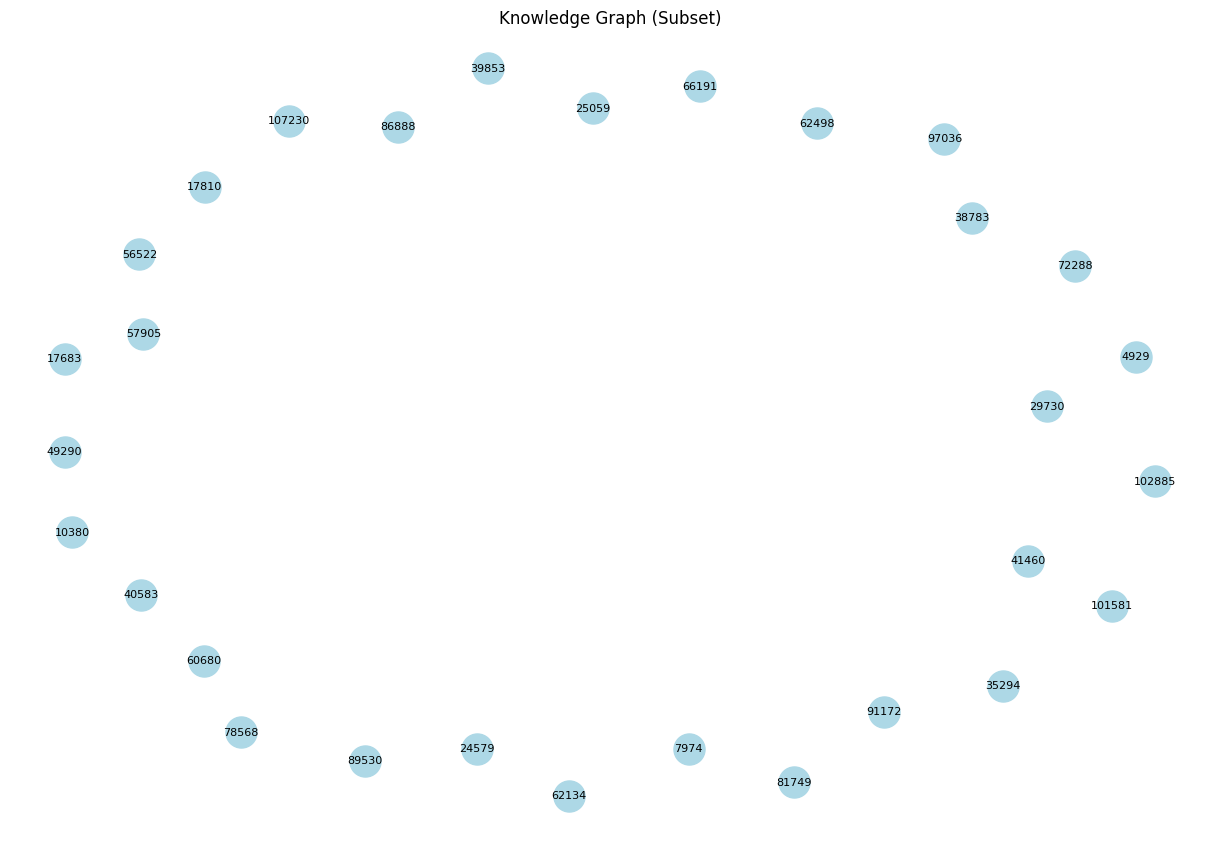

In [ ]:
# Small Visualization

KG = nx.DiGraph()

# Add nodes (entities)
all_entities = set(train_triples_df["Head_Entity"]).union(set(train_triples_df["Tail_Entity"]))
KG.add_nodes_from(all_entities)

# Add edges (relationships)
edges = list(zip(train_triples_df["Head_Entity"], train_triples_df["Tail_Entity"], train_triples_df["Relation_Name"]))
KG.add_edges_from([(h, t, {"relation": r}) for h, t, r in edges])

# Display Graph Info (Fixed)
print(f"Graph has {KG.number_of_nodes()} nodes and {KG.number_of_edges()} edges")

# Visualize a small subset of the graph
plt.figure(figsize=(12, 8))
subgraph_nodes = list(all_entities)[:30]  # First 30 nodes for visualization
subgraph = KG.subgraph(subgraph_nodes)
pos = nx.spring_layout(subgraph)  # Positioning
nx.draw(subgraph, pos, with_labels=True, node_size=500, node_color="lightblue", font_size=8)
edge_labels = {(h, t): d["relation"] for h, t, d in subgraph.edges(data=True)}
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=7)
plt.title("Knowledge Graph (Subset)")
plt.show()


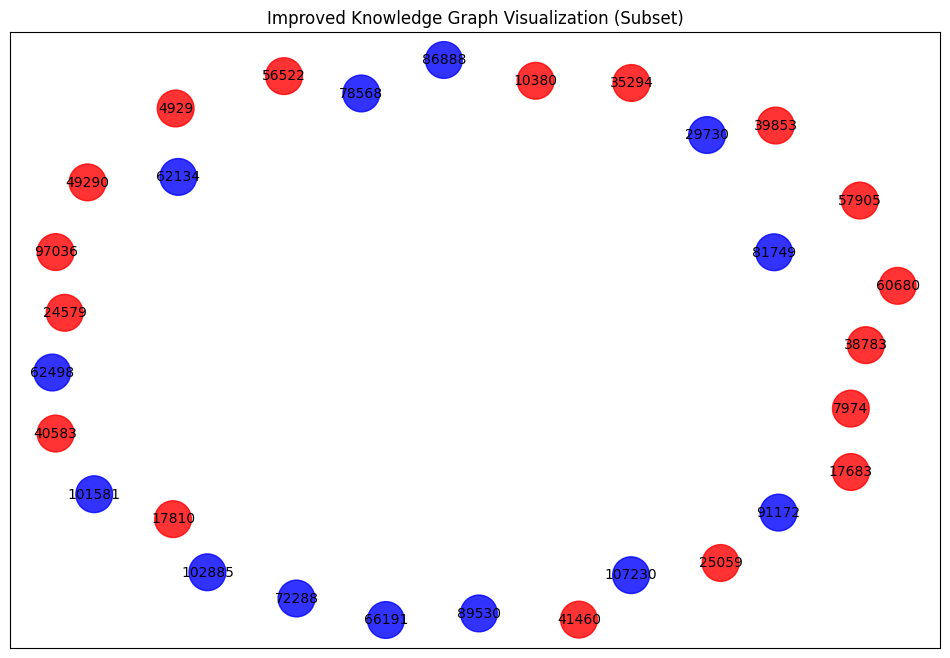

In [ ]:
# Add users, items

import networkx as nx
import matplotlib.pyplot as plt

# Extract user and item entity IDs
user_entities_df = kg_entities_df[kg_entities_df["Entity_Type"] == "user"]
item_entities_df = kg_entities_df[kg_entities_df["Entity_Type"] == "item"]

# Define color mapping based on entity type
entity_colors = {"user": "red", "item": "blue", "other": "green"}

# Choose a subset of nodes for better visualization
subgraph_nodes = list(KG.nodes())[:30]  # Adjust as needed
subgraph = KG.subgraph(subgraph_nodes)

# Create a color map for only the selected subset of nodes
node_colors = []
for node in subgraph_nodes:  # Ensure colors match the subset
    if node in user_entities_df["Entity_ID"].values:
        node_colors.append("red")  # User
    elif node in item_entities_df["Entity_ID"].values:
        node_colors.append("blue")  # Item
    else:
        node_colors.append("green")  # Other

# Use a spring layout for better visualization
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)  # Positioning layout

# Draw nodes with labels
nx.draw_networkx_nodes(subgraph, pos, node_size=700, node_color=node_colors, alpha=0.8)
nx.draw_networkx_labels(subgraph, pos, font_size=10, font_color="black")

# Draw edges with relationship labels
edge_labels = {(h, t): d["relation"] for h, t, d in subgraph.edges(data=True)}
nx.draw_networkx_edges(subgraph, pos, edge_color="gray", width=1.5, alpha=0.6)
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=8, font_color="darkblue")

# Title and show the improved graph
plt.title("Improved Knowledge Graph Visualization (Subset)")
plt.show()


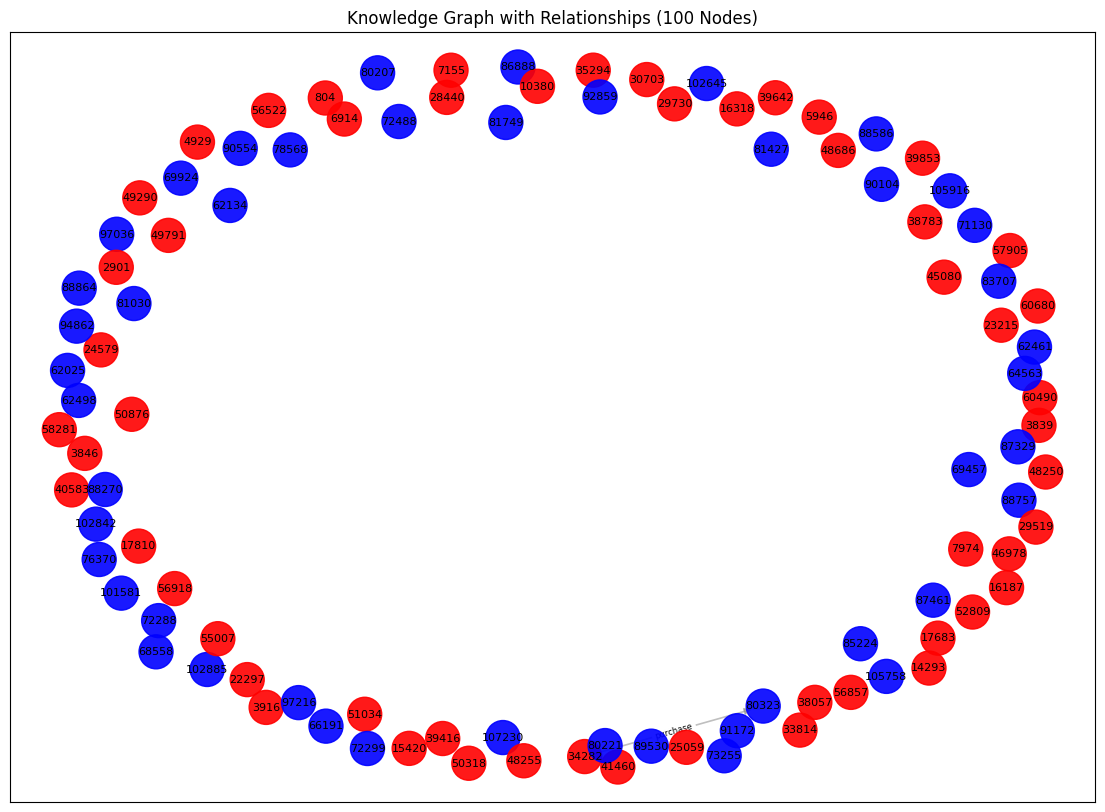

In [ ]:
# Bigger plot

# Select a larger subset for visualization
subset_size = 100  # Increase sample size
subgraph_nodes = list(KG.nodes)[:subset_size]
subgraph = KG.subgraph(subgraph_nodes)

# Assign colors based on entity type
node_colors = []
for node in subgraph.nodes():
    if node in user_entities_df["Entity_ID"].values:
        node_colors.append("red")  # Users
    else:
        node_colors.append("blue")  # Items

# Generate positions
pos = nx.spring_layout(subgraph, k=0.5, seed=42)  # Adjust k for better spacing

# Plot the graph
plt.figure(figsize=(14, 10))

# **Ensure edges are drawn**
nx.draw_networkx_edges(subgraph, pos, alpha=0.5, edge_color="gray", width=1.2)

# Draw nodes with labels
nx.draw_networkx_nodes(subgraph, pos, node_size=600, node_color=node_colors, alpha=0.9)
nx.draw_networkx_labels(subgraph, pos, font_size=8, font_color="black")

# Add edge labels for relationships
edge_labels = {(h, t): d["relation"] for h, t, d in subgraph.edges(data=True)}
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=6, label_pos=0.5)

# Set title
plt.title(f"Knowledge Graph with Relationships ({subset_size} Nodes)")
plt.show()


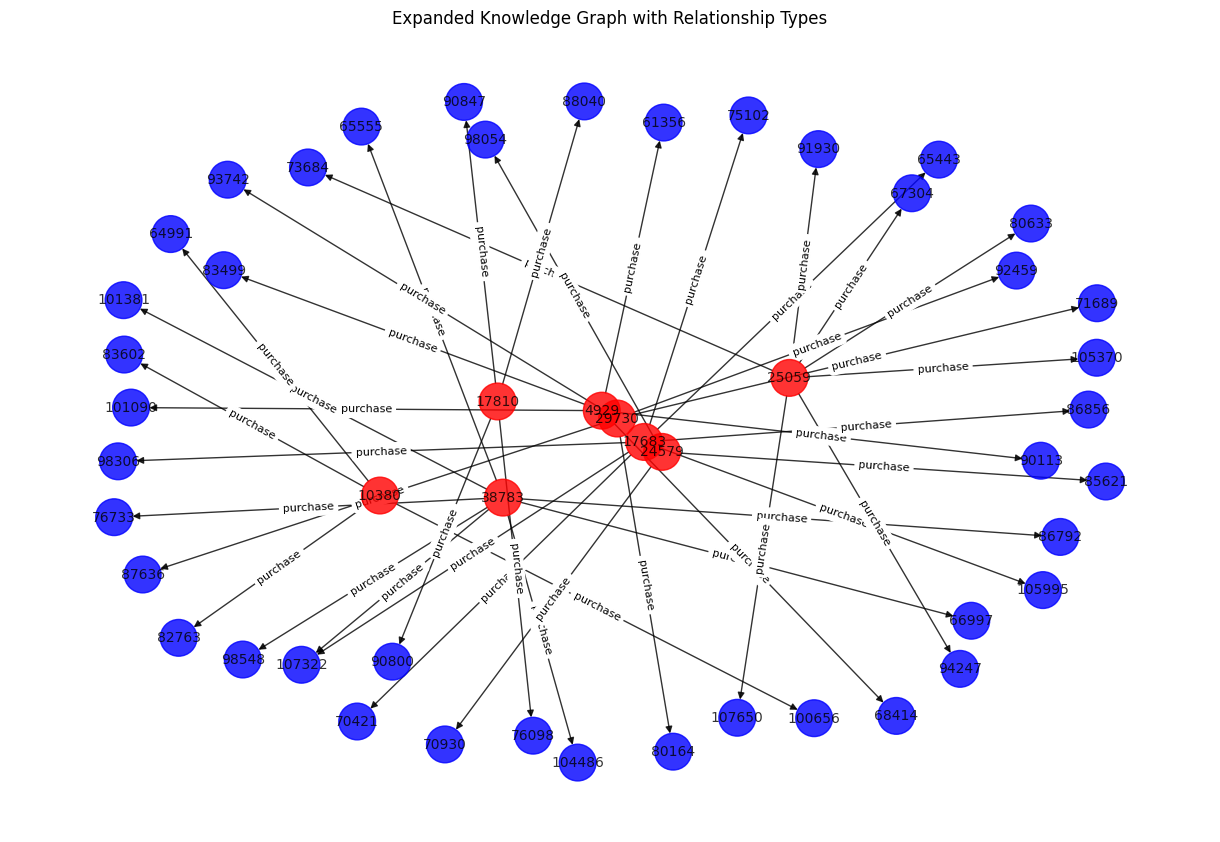

In [ ]:
# Show edges and relationship detail


subgraph_nodes = set()
for h, t, r in KG.edges(data=True):
    subgraph_nodes.add(h)
    subgraph_nodes.add(t)
    if len(subgraph_nodes) >= 50:  # Increase this number for larger graphs
        break

# Create a subgraph
subgraph = KG.subgraph(subgraph_nodes)

# Define position layout
pos = nx.spring_layout(subgraph, seed=42)

# Define colors for node types
node_colors = ["red" if node in user_entities_df["Entity_ID"].values else "blue" for node in subgraph.nodes()]

# Define edge colors based on relation type
edge_colors = []
for h, t, d in subgraph.edges(data=True):
    if d["relation"] == "purchase":
        edge_colors.append("black")
    elif d["relation"] == "review":
        edge_colors.append("green")
    elif d["relation"] == "reviewed_by":
        edge_colors.append("blue")
    else:
        edge_colors.append("gray")  # Default for unknown relations

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(subgraph, pos, with_labels=True, node_size=700, node_color=node_colors, font_size=10, edge_color=edge_colors, alpha=0.8)
edge_labels = {(h, t): d["relation"] for h, t, d in subgraph.edges(data=True)}
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=8)

plt.title("Expanded Knowledge Graph with Relationship Types")
plt.show()


In [ ]:
def get_recommendations_with_mapping(G, user_id, item_entities_df, n_recommendations=5):
    user_id = str(user_id)

    # Get user's purchased items and map to product IDs
    purchased_items = [edge[1] for edge in G.edges(user_id, data=True)
                      if edge[2]['relation'] == 'purchase']

    print("\nUser's Purchase History:")
    for entity_id in purchased_items:
        product_info = item_entities_df[item_entities_df['Entity_ID'] == entity_id]
        if not product_info.empty:
            product_id = product_info.iloc[0]['Entity_Name']
            print(f"- Product ID: {product_id} (Entity ID: {entity_id})")

    # Get recommendations
    recommendations = {}

    for item_id in purchased_items:
        for neighbor in G.neighbors(item_id):
            if neighbor not in purchased_items:
                edge_data = G.get_edge_data(item_id, neighbor)
                relation = edge_data['relation']

                # Scoring system
                score = 0
                if relation == 'also_buy':
                    score = 1.0
                elif relation == 'also_view':
                    score = 0.5
                elif relation == 'has_category':
                    score = 0.4
                elif relation == 'has_brand':
                    score = 0.4
                elif relation.startswith('has_style::') or relation.startswith('has_feature'):
                    score = 0.3

                if score > 0:
                    recommendations[neighbor] = recommendations.get(neighbor, 0) + score

    # Sort and get top recommendations
    sorted_recs = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)[:n_recommendations]

    print("\nTop Recommendations:")
    for entity_id, score in sorted_recs:
        # Map entity ID to product ID
        product_info = item_entities_df[item_entities_df['Entity_ID'] == entity_id]
        if not product_info.empty:
            product_id = product_info.iloc[0]['Entity_Name']
            print(f"\nRecommended Product ID: {product_id}")
            print(f"Entity ID: {entity_id}")
            print(f"Confidence Score: {score:.2f}")
            print("Recommended because:")

            # Show relationships to purchased items
            for purchased_entity_id in purchased_items:
                if G.has_edge(purchased_entity_id, entity_id):
                    relation = G.get_edge_data(purchased_entity_id, entity_id)['relation']
                    purchased_info = item_entities_df[item_entities_df['Entity_ID'] == purchased_entity_id]
                    if not purchased_info.empty:
                        purchased_product_id = purchased_info.iloc[0]['Entity_Name']
                        print(f"- Similar to your purchase: {purchased_product_id}")
                        print(f"  Relationship: {relation}")

    return sorted_recs

# Get recommendations with proper mapping
recommendations = get_recommendations_with_mapping(complete_KG, '0', item_entities_df)


User's Purchase History:
- Product ID: B006CBH0QI (Entity ID: 89707)
- Product ID: B00CRWLF58 (Entity ID: 80789)
- Product ID: B00A8XD8XU (Entity ID: 106201)
- Product ID: B00H5EKRB6 (Entity ID: 79580)
- Product ID: B004LSN0GS (Entity ID: 68872)
- Product ID: B00EYO3YFG (Entity ID: 108416)
- Product ID: B005SUHPVE (Entity ID: 90652)
- Product ID: B0090ZVACS (Entity ID: 63321)
- Product ID: B00D1HLUP8 (Entity ID: 99801)
- Product ID: 7508492919 (Entity ID: 93588)

Top Recommendations:


In [ ]:
def get_product_recommendations(G, user_id, item_entities_df, n_recommendations=5):
    user_id = str(user_id)
    purchased_items = [edge[1] for edge in G.edges(user_id, data=True)
                      if edge[2]['relation'] == 'purchase']

    print("\nUser's Purchase History:")
    for entity_id in purchased_items:
        product_info = item_entities_df[item_entities_df['Entity_ID'] == entity_id]
        if not product_info.empty:
            product_id = product_info.iloc[0]['Entity_Name']
            print(f"- Product ID: {product_id} (Entity ID: {entity_id})")

    # Track product recommendations only (not features)
    product_recommendations = {}

    for item_id in purchased_items:
        # First get all "also_buy" and "also_view" direct product recommendations
        for neighbor in G.neighbors(item_id):
            if neighbor in item_entities_df['Entity_ID'].values:  # Only consider product entities
                edge_data = G.get_edge_data(item_id, neighbor)
                relation = edge_data['relation']

                if relation == 'also_buy':
                    product_recommendations[neighbor] = product_recommendations.get(neighbor, 0) + 1.0
                elif relation == 'also_view':
                    product_recommendations[neighbor] = product_recommendations.get(neighbor, 0) + 0.5

    # Sort and get top recommendations
    sorted_recs = sorted(product_recommendations.items(), key=lambda x: x[1], reverse=True)[:n_recommendations]

    print("\nTop Recommendations:")
    for entity_id, score in sorted_recs:
        product_info = item_entities_df[item_entities_df['Entity_ID'] == entity_id]
        if not product_info.empty:
            product_id = product_info.iloc[0]['Entity_Name']
            print(f"\nRecommended Product: {product_id}")
            print(f"Confidence Score: {score:.2f}")
            print("Recommended because:")

            # Show which purchases led to this recommendation
            for purchased_id in purchased_items:
                edge_data = G.get_edge_data(purchased_id, entity_id)
                if edge_data:
                    purchased_info = item_entities_df[item_entities_df['Entity_ID'] == purchased_id]
                    if not purchased_info.empty:
                        print(f"- {edge_data['relation']} with your purchase: {purchased_info.iloc[0]['Entity_Name']}")

    return sorted_recs

# Get recommendations focusing on actual products
recommendations = get_product_recommendations(complete_KG, '0', item_entities_df)


User's Purchase History:
- Product ID: B006CBH0QI (Entity ID: 89707)
- Product ID: B00CRWLF58 (Entity ID: 80789)
- Product ID: B00A8XD8XU (Entity ID: 106201)
- Product ID: B00H5EKRB6 (Entity ID: 79580)
- Product ID: B004LSN0GS (Entity ID: 68872)
- Product ID: B00EYO3YFG (Entity ID: 108416)
- Product ID: B005SUHPVE (Entity ID: 90652)
- Product ID: B0090ZVACS (Entity ID: 63321)
- Product ID: B00D1HLUP8 (Entity ID: 99801)
- Product ID: 7508492919 (Entity ID: 93588)

Top Recommendations:

Recommended Product: B00N0YYGIU
Confidence Score: 1.00
Recommended because:
- also_buy with your purchase: B00A8XD8XU

Recommended Product: B00BT7RAPG
Confidence Score: 1.00
Recommended because:
- also_buy with your purchase: B00A8XD8XU

Recommended Product: B005SUHRH6
Confidence Score: 1.00
Recommended because:
- also_buy with your purchase: B005SUHPVE

Recommended Product: B01F6AOLSK
Confidence Score: 1.00
Recommended because:
- also_buy with your purchase: B005SUHPVE

Recommended Product: B01FH14JC6
C

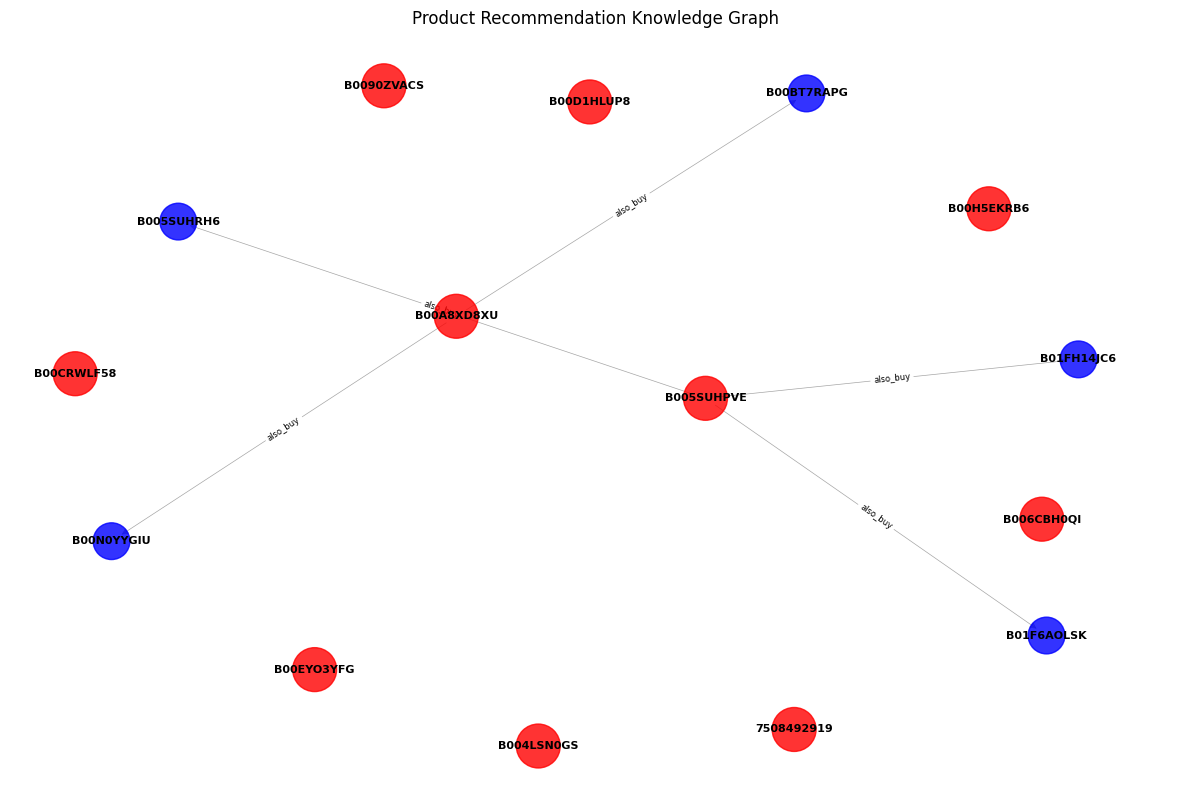

In [ ]:
def visualize_recommendations(G, user_id, item_entities_df, recommendations):
    import networkx as nx
    import matplotlib.pyplot as plt

    # Create a new graph for visualization
    rec_graph = nx.DiGraph()

    # Get purchased items for this user
    purchased_items = [edge[1] for edge in G.edges(user_id, data=True)
                       if edge[2]['relation'] == 'purchase']

    # Add purchased items as nodes
    for item_id in purchased_items:
        rec_graph.add_node(item_id, type='purchased')

    # Add recommended items and their connections
    for rec_id, score in recommendations:
        rec_graph.add_node(rec_id, type='recommended')

        # Connect to the original purchase that led to this recommendation
        for purchased_id in purchased_items:
            edge_data = G.get_edge_data(purchased_id, rec_id)
            if edge_data:
                rec_graph.add_edge(purchased_id, rec_id,
                                   relation=edge_data['relation'],
                                   weight=score)

    # Visualization
    plt.figure(figsize=(12, 8))

    # Prepare node colors
    node_colors = ['red' if rec_graph.nodes[node].get('type') == 'purchased'
                   else 'blue' for node in rec_graph.nodes()]

    # Prepare node sizes
    node_sizes = [1000 if rec_graph.nodes[node].get('type') == 'purchased'
                  else 700 for node in rec_graph.nodes()]

    # Layout
    pos = nx.spring_layout(rec_graph, k=0.5, iterations=50)

    # Draw nodes
    nx.draw_networkx_nodes(rec_graph, pos,
                            node_color=node_colors,
                            node_size=node_sizes,
                            alpha=0.8)

    # Draw labels with product names
    labels = {}
    for node in rec_graph.nodes():
        product_info = item_entities_df[item_entities_df['Entity_ID'] == node]
        if not product_info.empty:
            labels[node] = product_info.iloc[0]['Entity_Name']
        else:
            labels[node] = str(node)

    nx.draw_networkx_labels(rec_graph, pos, labels, font_size=8, font_weight="bold")

    # Draw edges
    edges = list(rec_graph.edges())
    weights = [rec_graph[u][v].get('weight', 1) for u, v in edges]
    nx.draw_networkx_edges(rec_graph, pos,
                            edge_color='gray',
                            width=[w/2 for w in weights],
                            alpha=0.7,
                            arrows=True)

    # Draw edge labels
    edge_labels = {(u,v): rec_graph[u][v]['relation'] for (u,v) in rec_graph.edges()}
    nx.draw_networkx_edge_labels(rec_graph, pos,
                                  edge_labels=edge_labels,
                                  font_size=6)

    plt.title("Product Recommendation Knowledge Graph")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize the recommendations
visualize_recommendations(complete_KG, '0', item_entities_df, recommendations)

Output shows 10 purchases, two of which have recommened additional purchases.